In [ ]:
# Google Colab setup for Kaggle API

from google.colab import files

!pip install -q kaggle

files.upload()

!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# 1. Download the full zip (it's big, but reliable)
!kaggle datasets download -d mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot

# 2. Extract ONLY the DNN-EdgeIIoT-dataset.csv file
# The -j flag flattens the directory structure so it drops right into your current folder
!unzip -j edgeiiotset-cyber-security-dataset-of-iot-iiot.zip "*DNN-EdgeIIoT-dataset.csv" "*ML-EdgeIIoT-dataset.csv" -d .

# 3. Verify it's there
!ls -lh DNN-EdgeIIoT-dataset.csv

^C
Archive:  edgeiiotset-cyber-security-dataset-of-iot-iiot.zip
replace ./DNN-EdgeIIoT-dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd

import numpy as np

df_ml = pd.read_csv('ML-EdgeIIoT-dataset.csv', low_memory=False)
# df_dl = pd.read_csv('DNN-EdgeIIoT-dataset.csv', low_memory=False)

# Standard Preprocessing
Prepprocess the data in accordance to steps outlined in EdgeIIoT paper

In [3]:
import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import re


def preprocess(df, output_path=None):
    df = df.copy()
    
    # Drop columns
    drop_columns = [
        "frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4", 
        "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp",
        "http.request.uri.query", "tcp.options", "tcp.payload", "tcp.srcport",
        "tcp.dstport", "udp.port", "mqtt.msg"
    ]
    df.drop(drop_columns, axis=1, inplace=True, errors='ignore')
    
    # Drop NaN and duplicates
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df, random_state=42)
    
    # Encode categorical features
    def encode_text_dummy(df, name):
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = f"{name}-{x}"
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)
    
    encode_text_dummy(df, 'http.request.method')
    encode_text_dummy(df, 'http.referer')
    encode_text_dummy(df, "http.request.version")
    encode_text_dummy(df, "dns.qry.name.len")
    encode_text_dummy(df, "mqtt.conack.flags")
    encode_text_dummy(df, "mqtt.protoname")
    encode_text_dummy(df, "mqtt.topic")
    
    # Encode labels
    le = LabelEncoder()
    df['Attack_type'] = le.fit_transform(df['Attack_type'])
    
    # Create mapping dictionary
    label_map = {idx: label for idx, label in enumerate(le.classes_)}
    
    # Scale features
    X = df.drop('Attack_type', axis=1)
    y = df['Attack_type']
    
    scaler = StandardScaler() # Could use Robust Scaling?
    X_scaled = scaler.fit_transform(X)
    
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled['Attack_type'] = y.values
    
    # Handle special characters in column names created from encoding
    df_scaled.columns = [re.sub(r'[^A-Za-z0-9_]', '_', col) for col in df_scaled.columns]
    
    # Save
    if output_path:
        df_scaled.to_csv(output_path, index=False)
    
    return df_scaled, label_map

# df_dl_preprocessed, labels_dl = preprocess(df_dl)
df_ml_preprocessed, labels_ml = preprocess(df_ml)
    

In [4]:
from sklearn.model_selection import train_test_split
X = df_ml_preprocessed.drop('Attack_type', axis=1)
y = df_ml_preprocessed['Attack_type']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 91317
Val size: 30439
Test size: 30440


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                            precision_score, recall_score, accuracy_score)

def evaluate_models(models, X_train, y_train, X_val, y_val, label_map):
    """
    Train and evaluate multiple models on validation set.
    
    Parameters:
    -----------
    models : dict
        Dictionary of model_name: model_instance
    X_train : DataFrame or array
        Training features
    y_train : Series or array
        Training labels
    X_val : DataFrame or array
        Validation features
    y_val : Series or array
        Validation labels
    label_map : dict
        Dictionary mapping label indices to names
    
    Returns:
    --------
    dict : Results dictionary with predictions and confusion matrices
    """
    results = {}
    target_names = [label_map[i] for i in sorted(label_map.keys())]
    
    for name, model in models.items():
        print(f"\n{'='*80}")
        print(f"Training {name}...")
        print('='*80)
        
        # Train on full training set
        model.fit(X_train, y_train)
        
        # Predict on val set
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        print(f"\n{name} Validation Set Results:")
        print(f"  Accuracy:         {accuracy_score(y_val, y_pred):.4f}")
        print(f"  Precision Macro:  {precision_score(y_val, y_pred, average='macro'):.4f}")
        print(f"  Precision Weight: {precision_score(y_val, y_pred, average='weighted'):.4f}")
        print(f"  Recall Macro:     {recall_score(y_val, y_pred, average='macro'):.4f}")
        print(f"  Recall Weight:    {recall_score(y_val, y_pred, average='weighted'):.4f}")
        print(f"  F1 Macro:         {f1_score(y_val, y_pred, average='macro'):.4f}")
        print(f"  F1 Weight:        {f1_score(y_val, y_pred, average='weighted'):.4f}")
        
        # Classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_val, y_pred, target_names=target_names))
        
        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(f'{name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        results[name] = {
            'y_pred': y_pred,
            'confusion_matrix': cm,
            'accuracy': accuracy_score(y_val, y_pred),
            'f1_macro': f1_score(y_val, y_pred, average='macro'),
            'f1_weighted': f1_score(y_val, y_pred, average='weighted')
        }
    
    print("\n" + "="*80)
    print("EVALUATION COMPLETE")
    print("="*80)
    
    return results


# Baseline Results:
Standard preprocessing, no hyperparameter tuning, no SMOTE

Using traditional ML models shown to perform well on various kaggle competitions (XGBoost, CatBoost, RandomForest, LightGBM)

In [ ]:
!pip install xgboost catboost lightgbm


Training XGBoost...

XGBoost Validation Set Results:
  Accuracy:         0.9464
  Precision Macro:  0.9398
  Precision Weight: 0.9471
  Recall Macro:     0.9250
  Recall Weight:    0.9464
  F1 Macro:         0.9309
  F1 Weight:        0.9462

XGBoost Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.96      1973
            DDoS_HTTP       0.90      0.94      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.89      0.67      0.77       171
                 MITM       1.00      0.99      0.99        72
               Normal       1.00      1.00      1.00      4820
             Password       0.85      0.82      0.83      1994
        Port_Scanning       0.94      1.00      0.97      1784
           Ransomware       0.9

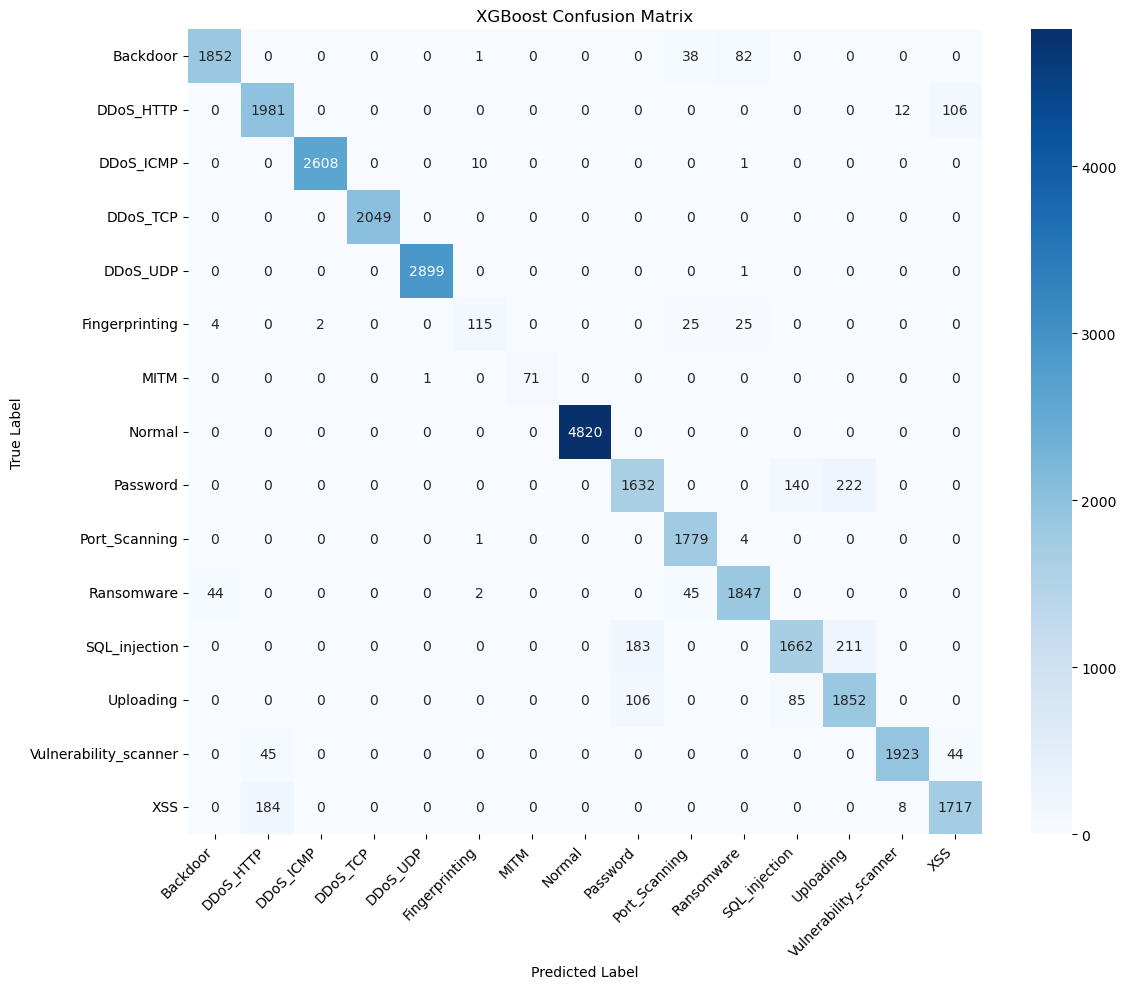


Training CatBoost...


KeyboardInterrupt: 

In [11]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

models_baseline = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0, thread_count=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    
}

results_baseline = evaluate_models(models_baseline, X_train, y_train, X_val, y_val, labels_ml)

# Ensemble Classifiers
Questions to answer:
1. Does combining our existing models in an ensemble improve performance?
2. Stacking or voting?
3. If stacking, which model performs the best as a final estimator?


Training Voting Ensemble...

Voting Ensemble Validation Set Results:
  Accuracy:         0.9449
  Precision Macro:  0.9394
  Precision Weight: 0.9453
  Recall Macro:     0.9255
  Recall Weight:    0.9449
  F1 Macro:         0.9312
  F1 Weight:        0.9448

Voting Ensemble Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.96      1973
            DDoS_HTTP       0.90      0.94      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.91      0.69      0.79       171
                 MITM       1.00      1.00      1.00        72
               Normal       1.00      1.00      1.00      4820
             Password       0.82      0.83      0.82      1994
        Port_Scanning       0.94      1.00      0.97      1784
       

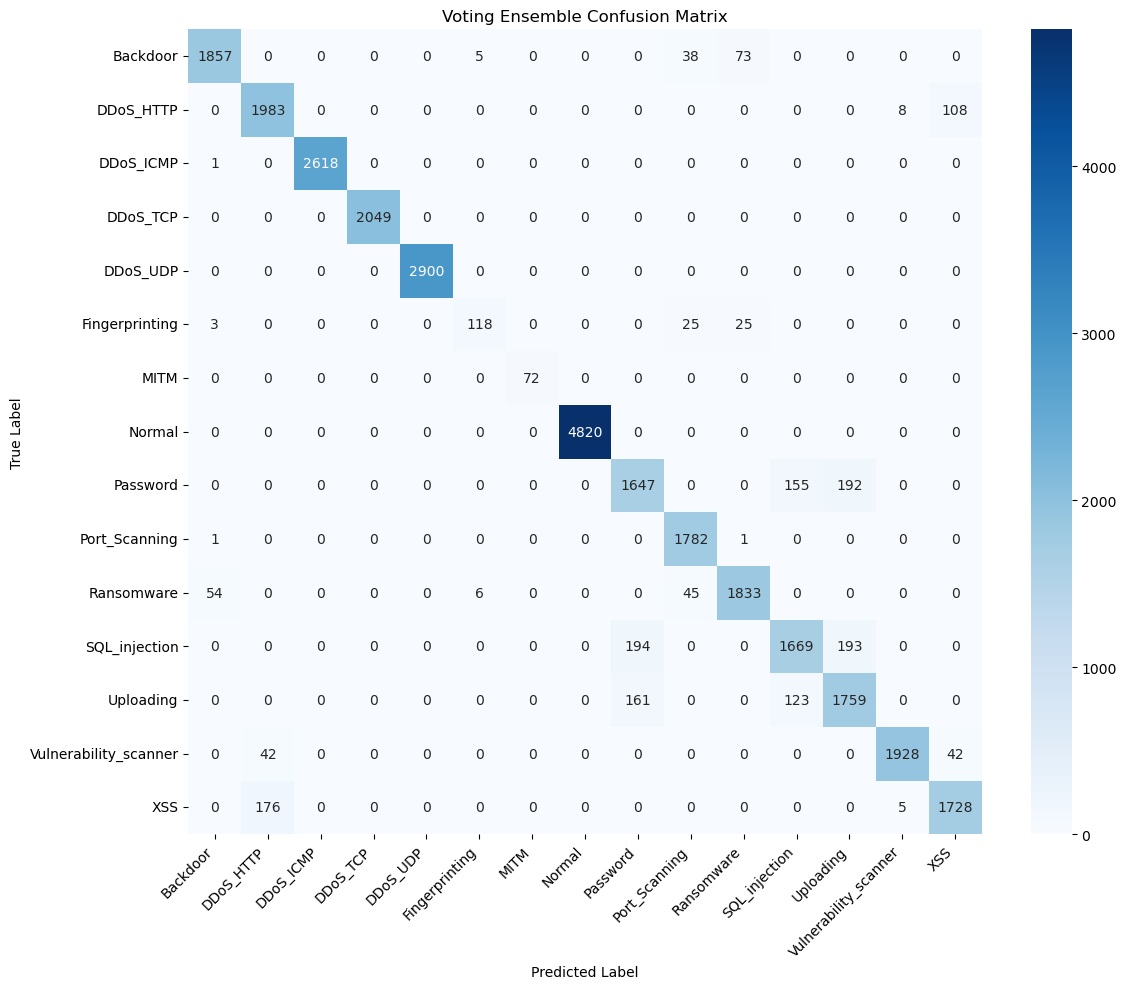


Training Stacking Ensemble (XGB)...

Stacking Ensemble (XGB) Validation Set Results:
  Accuracy:         0.9444
  Precision Macro:  0.9436
  Precision Weight: 0.9458
  Recall Macro:     0.9240
  Recall Weight:    0.9444
  F1 Macro:         0.9315
  F1 Weight:        0.9443

Stacking Ensemble (XGB) Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.95      1973
            DDoS_HTTP       0.89      0.95      0.92      2099
            DDoS_ICMP       1.00      1.00      1.00      2619
             DDoS_TCP       1.00      1.00      1.00      2049
             DDoS_UDP       1.00      1.00      1.00      2900
       Fingerprinting       0.98      0.69      0.81       171
                 MITM       1.00      0.99      0.99        72
               Normal       1.00      1.00      1.00      4820
             Password       0.87      0.80      0.83      1994
        Port_Scanning       0.94      1.00    

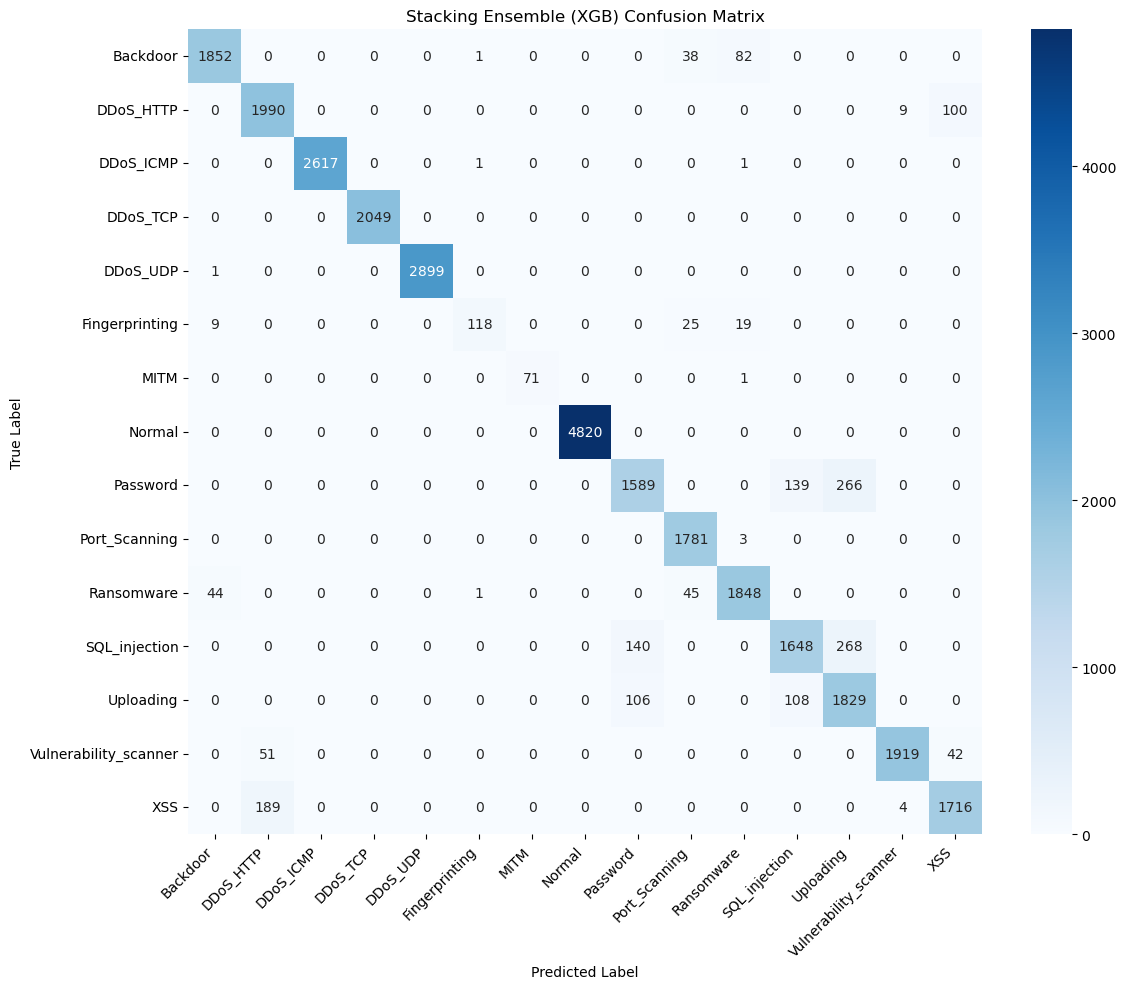


EVALUATION COMPLETE


In [6]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

voting_model = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)),
        # ('cat', CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)), NOTE: errors with sklearn tags in ensemble, temporarily removed
        ('lgbm', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ],
    voting='soft'
)

stacking_model_xgb = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)),
        # ('cat', CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)), NOTE: errors with sklearn tags in ensemble, temporarily removed
        ('lgbm', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ],
    final_estimator=XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)
)

models_ensemble = {
    "Voting Ensemble": voting_model,
    "Stacking Ensemble (XGB)": stacking_model_xgb
}

results_ensemble = evaluate_models(models_ensemble, X_train, y_train, X_val, y_val, labels_ml)

# Results:
**CatBoost** appears as the best performing model, although hard to tell due to the fact I cannot get catboost to work in sklearn ensemble classifiers.

Across the board, it seems like the worst performing class is **Fingerprinting**, next steps likely involve adjusting preprocessing to improve performance in that class.

In [6]:
# Which features does the best performing model on Fingerprinting care the most about?
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
cat.fit(X_train, y_train)

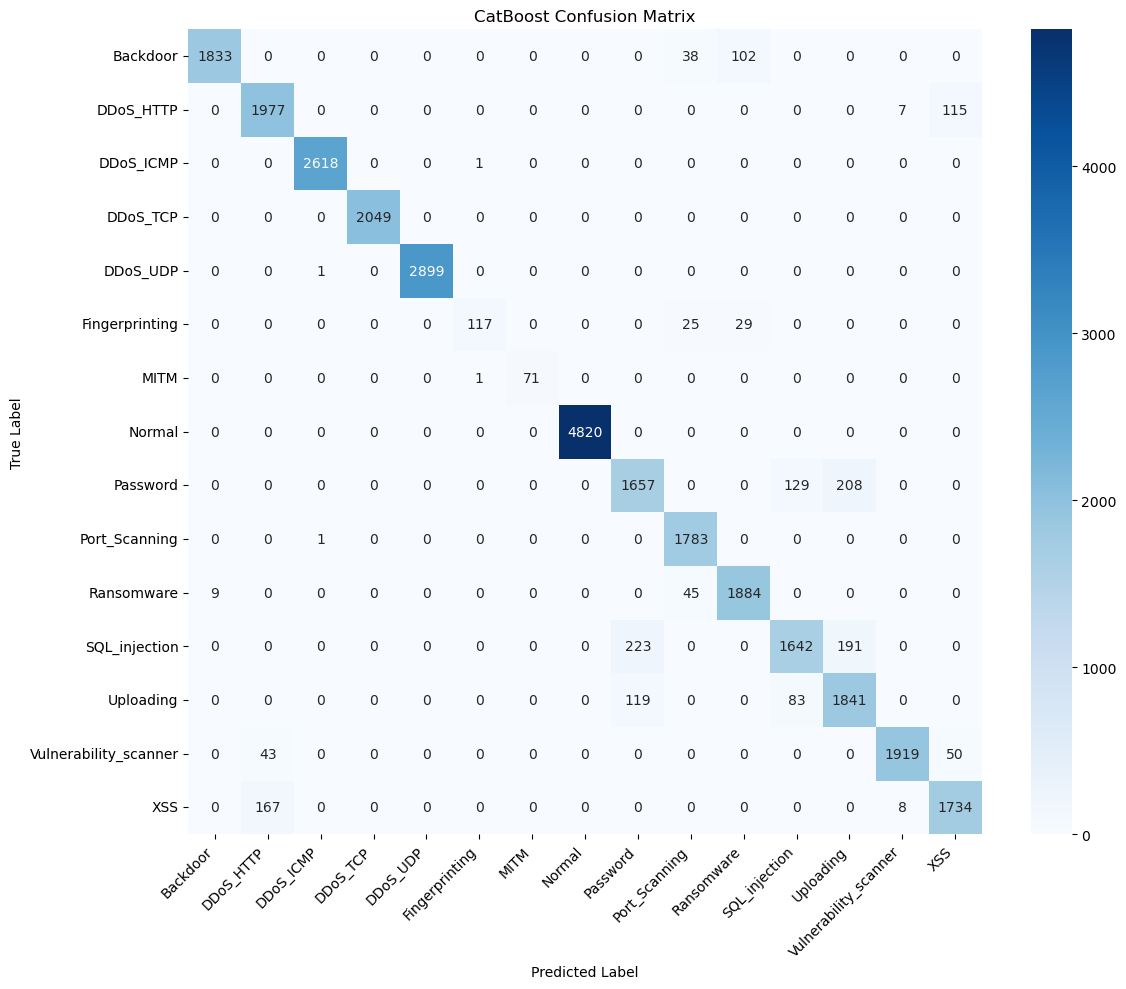

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = cat.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
target_names = [labels_ml[i] for i in sorted(labels_ml.keys())]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'CatBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

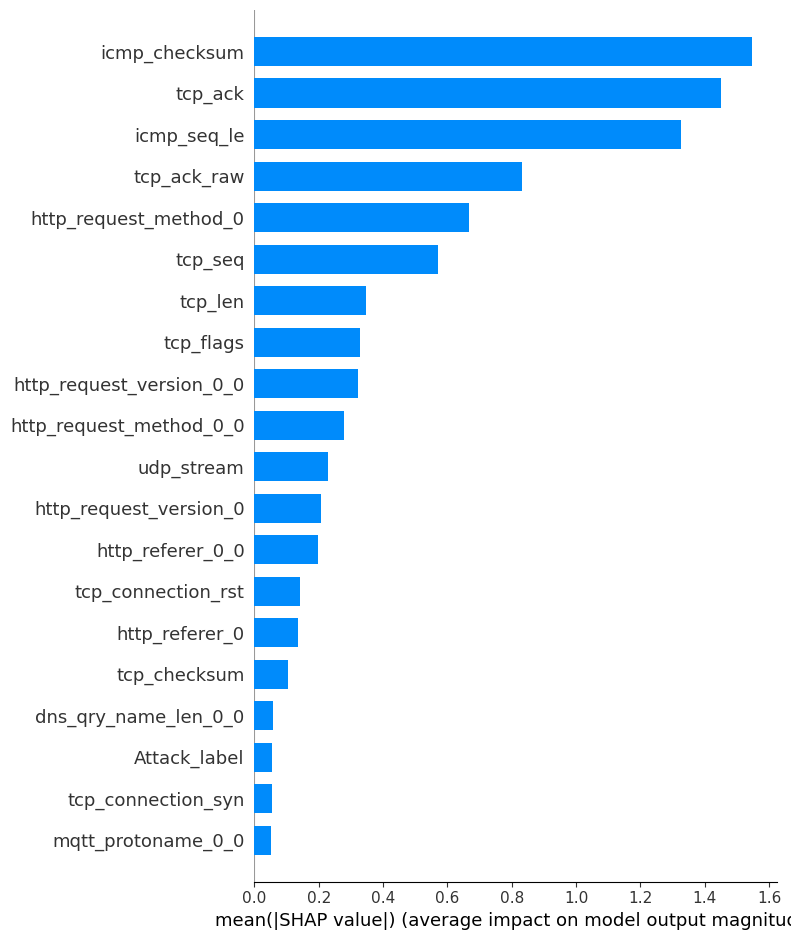

In [13]:
import shap
explainer = shap.TreeExplainer(cat)

fingerprint_label = [key for key, value in labels_ml.items() if value == 'Fingerprinting'][0]
shap_values = explainer.shap_values(X_val[y_val == fingerprint_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, fingerprint_label]
else:
    sv = shap_values[fingerprint_label]

shap.summary_plot(sv, 
                  X_val[y_val == fingerprint_label], 
                  feature_names=X_train.columns,
                  plot_type="bar")

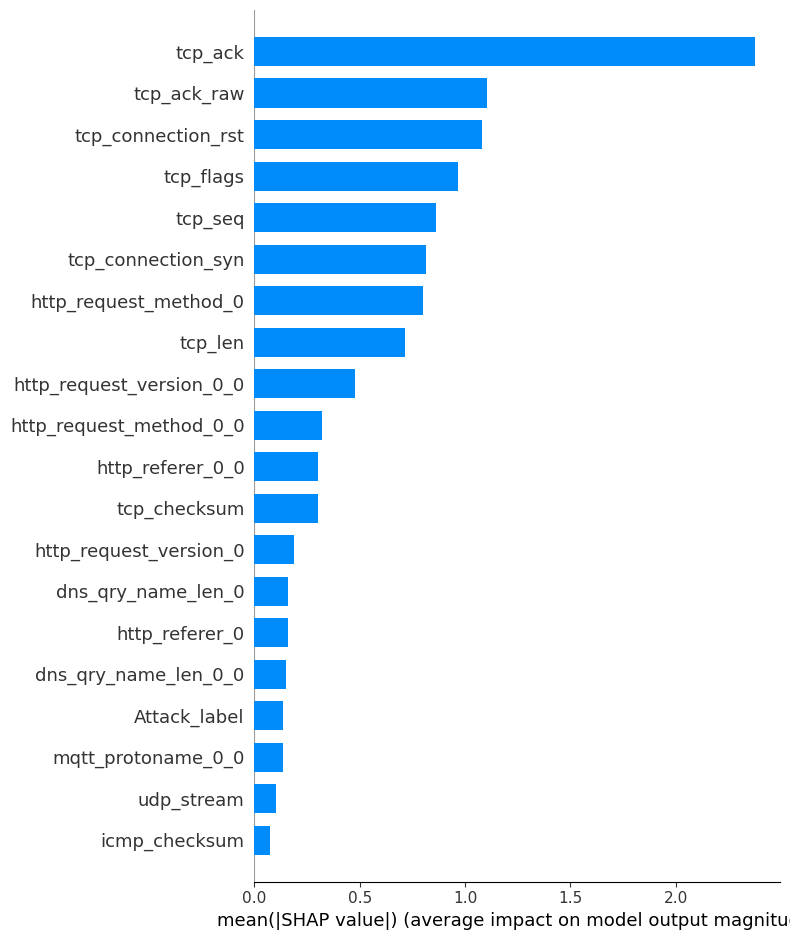

In [14]:
fingerprint_label = [key for key, value in labels_ml.items() if value == 'Port_Scanning'][0]
shap_values = explainer.shap_values(X_val[y_val == fingerprint_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, fingerprint_label]
else:
    sv = shap_values[fingerprint_label]

shap.summary_plot(sv, 
                  X_val[y_val == fingerprint_label], 
                  feature_names=X_train.columns,
                  plot_type="bar")

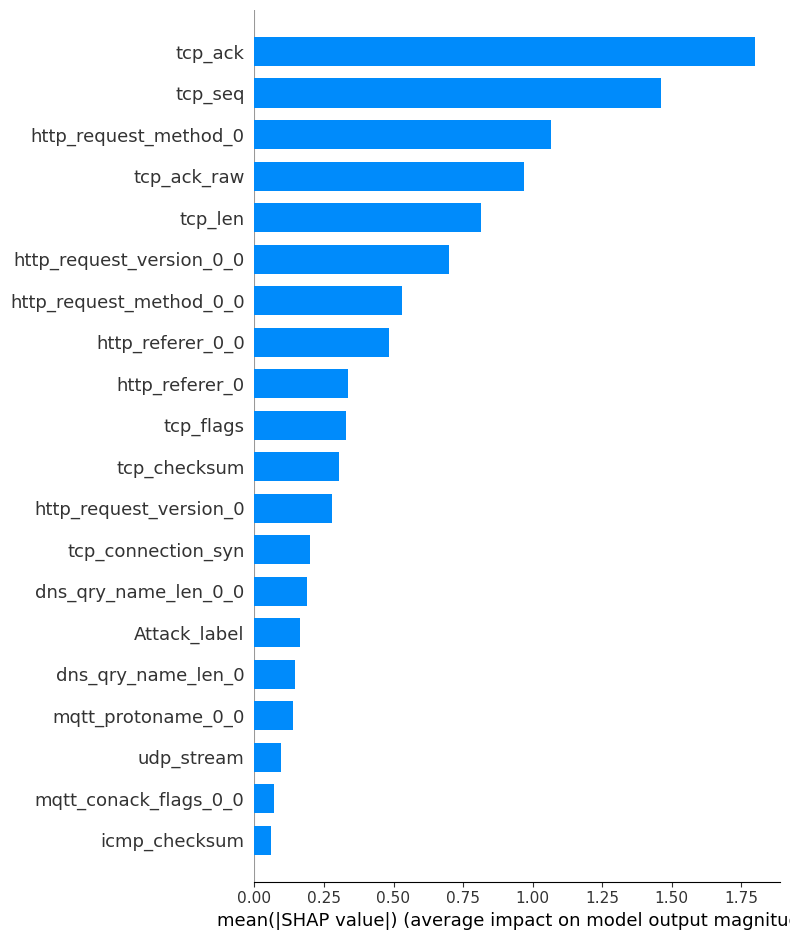

In [15]:
fingerprint_label = [key for key, value in labels_ml.items() if value == 'Ransomware'][0]
shap_values = explainer.shap_values(X_val[y_val == fingerprint_label])

# Handle CatBoost's 3D shap output (n_samples, n_features, n_classes)
if hasattr(shap_values, 'shape') and len(shap_values.shape) == 3:
    sv = shap_values[:, :, fingerprint_label]
else:
    sv = shap_values[fingerprint_label]

shap.summary_plot(sv, 
                  X_val[y_val == fingerprint_label], 
                  feature_names=X_train.columns,
                  plot_type="bar")